# Bruk av geopandas med data fra NVDB og SSB

Demo av hvordan geopandas kan brukes med data fra [Nasjonal vegdatabank](https://www.vegvesen.no/fag/teknologi/Nasjonal+vegdatabank) (NVDB) og [Statistisk Sentralbyrå](http://www.ssb.no/natur-og-miljo/geodata) (SSB). 

Vi ønsker å finne hvilke turistveger som går gjennom hvilke tettsteder - og hvilke trafikkulykker som er registrert der. 

Gangen er som følger: 
1. [Installasjon](installasjon.md) 
1. Last ned data over tettsteder fra [SSB](http://www.ssb.no/natur-og-miljo/geodata
1. Last ned turistveger fra [NVDB api](https://www.vegvesen.no/nvdb/apidokumentasjon/)
1. Finn snittet av turistveger og tettsteder (hvilke turistveger som går gjennom hvilke tettsteder)
1. Last ned trafikkulykker på turistvegene  
    1. Vi bruker NVDB api'ets [overlappfilter](https://www.vegvesen.no/nvdb/apidokumentasjon/#/parameter/overlappfilter)
1. Finn snittet av trafikkulykker mot tettsteder med turistveger.


## [Installasjon](installasjon.md) 

[Installasjon](installasjon.md) 

## Importer de bibliotekene som trengs

In [1]:
# Fine plott og sånn
%matplotlib notebook 
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt


# For nedlasting fra SSB
import requests
import zipfile
import io
import os

# For å hente data fra NVDB api 
import nvdbapi      # Fra https://github.com/LtGlahn/nvdbapi-V2
import nvdb2geojson # Fra https://github.com/LtGlahn/nvdbapi-V2

# For datakverning og analyse
import geopandas as gpd
import pandas as pd



# Last ned data fra SSB

In [2]:
# Se https://stackoverflow.com/a/14260592 , det om python 3+

url = 'http://www.ssb.no/natur-og-miljo/_attachment/286736?_ts=158d3354ee0'

# Laster kun en gang: 
if not os.path.exists('Tettsted2016/Tettsted2016.shp'):
    r = requests.get(url)
    if r.ok: 
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()
    else: 
        print( "Nedlasting feiler:", r.status_code, r.reason )

### Hent SSB-data manuelt 

Dette steget kan også gjøres manuelt. Direkte lenke for nedlasting av 2016-datasett er http://www.ssb.no/natur-og-miljo/_attachment/286736?_ts=158d3354ee0 

*NB! Det vil ikke overraske meg om lenkeråte gjør at du uansett må inn på SSB og finne nedlastingslenker* 

#### Finn lenke til nedlasting på SSB's nettsider

1. Gå inn på http://www.ssb.no/natur-og-miljo/geodata#Nedlasting_av_datasett_med_dynamiske_avgrensinger . 
1. Klikk på *Nedlasting av kart over tettsteder*. 
1. Klikk på det året du vil laste ned for. 
    1. Nedlasting skal starte automagisk... hvis ikke kan du prøve en annen nettleser, evt kopiere lenken og bruke verktøy som curl eller wget. 
1. Pakk ut zip-arkivet og legg mappen ```Tettsted2016``` sammen med øvrige filer (rotnivå i repos'et). Dvs at stien til shapefilen skal være ```Tettsted2016/Tettsted2016.shp```

### Les tettsted inn i geodata-frame 

Vi leser tettstedene inn i geodata-frame og knar litt på dem. 

In [56]:
# Les inn tettsted i geodata-frame
tettsted = gpd.read_file( 'Tettsted2016/Tettsted2016.shp')

# Hvilke egenskaper (kolonner) har vi? 
tettsted.columns

Index(['Tot_Bef', 'TETTNR', 'Tettstedsn', 'Areal_km2', 'Beff_tett',
       'geometry'],
      dtype='object')

Bortsett fra kolonnen _geometry_ så er dette en vanlig pandas dataframe. 

La oss kna litt mer. Hva er f.eks. forholdet mellom areal og folketall? La oss plotte det

<IPython.core.display.Javascript object>


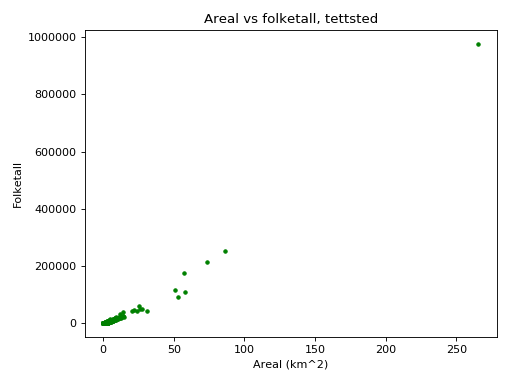

In [57]:
fig2, ax2 = plt.subplots()
ax2.set_title( "Areal vs folketall, tettsted")
ax2.set_xlabel( 'Areal (km^2)')
ax2.set_ylabel( 'Folketall')
ax2.plot( tettsted.Areal_km2, tettsted.Tot_Bef, '.g' );
fig2.tight_layout()

Interessant.La oss se på hva som særpreger tettsteder større enn 50 km${}^2$. 

In [55]:
tettsted[ tettsted.Areal_km2 > 50].sort_values('Areal_km2', ascending=False )

,Tot_Bef,TETTNR,Tettstedsn,Areal_km2,Beff_tett,geometry
300,975744,0801,Oslo,265.652192,3673.013168,"(POLYGON ((266251.6812000013 6629989.145, 2662..."
442,252772,5001,Bergen,86.496447,2922.339680,"(POLYGON ((-38070.00590000088 6718696.3411, -3..."
109,213312,4522,Stavanger/Sandnes,73.607289,2897.973869,"(POLYGON ((-34431.14089999912 6556225.3978, -3..."
148,109907,0022,Fredrikstad/Sarpsborg,58.183978,1888.956445,"(POLYGON ((264590.8479000007 6568949.3261, 264..."
744,177617,6501,Trondheim,57.491220,3089.463031,(POLYGON ((268265.0573999999 7030054.580200002...
143,92001,3005,Porsgrunn/Skien,52.675749,1746.553230,(POLYGON ((195972.8235999987 6553963.442600001...
273,115137,2003,Drammen,50.984945,2258.254846,(POLYGON ((232735.5022999992 6624973.380599999...


# Les data fra Nasjonal vegdatabank

In [23]:
turistveger = nvdbapi.nvdbFagdata(777)
turistveger_geojson = nvdb2geojson.fagdata2geojson( turistveger)

In [4]:
turist2 = gpd.GeoDataFrame.from_features( turistveger_geojson['features'])

# Finn turistveger i tettsteder 

http://geopandas.org/mergingdata.html , spatial joins. 



In [41]:
tettsted.crs = {'init': 'epsg:25833'}
turist2.crs = {'init': 'epsg:25833'}

turist_i_tettsted = gpd.sjoin( turist2, tettsted, how='inner', op='intersects')
tettsted_m_turist = gpd.sjoin( tettsted, turist2, how='inner', op='intersects')


_Hvis du her får en kryptisk **RuntimeWarning**- advarsel over så kan du trygt ignorere det. Eldre versjoner av programvaren gir divisjon med 0 når vi ikke får treff på "join" - operasjonen._

La oss sjekke hvor mange vi fant: 

In [6]:
print( "Antall segmenter med turistveger", len( turist2))
print( "Antall tettsteder", len(tettsted))
print( "Tettsteder med turistveger", len(tettsted_m_turist), "Med  DUPLIKATER?")
print( "Turistveger som går gjennom tettsteder", len(turist_i_tettsted))

Antall segmenter med turistveger 527
Antall tettsteder 990
Tettsteder med turistveger 120 Med  DUPLIKATER?
Turistveger som går gjennom tettsteder 120


Våre 17 turistveger er splittet opp i 527 korte segmenter - og overgangen mellom segmentene er ofte i vegkryss, dvs vi har typisk mer enn ett turistveg-segment per tettsted. Det gir duplikater som må fjernes fra datasettet _tettsteder med turistveger_

In [7]:
tettsted_m_turist.drop_duplicates( subset='TETTNR', inplace=True)
print( "Tettsteder med turistveger", len(tettsted_m_turist), "UTEN duplikater")

Tettsteder med turistveger 44 UTEN duplikater


# Finner trafikkulykker på turistveger

Bruker NVDB api's overlappfilter https://www.vegvesen.no/nvdb/apidokumentasjon/#/parameter/overlappfilter 


In [22]:
ulykker = nvdbapi.nvdbFagdata( 570)
ulykker.addfilter_overlapp( '777'  )
print( 'Antall ulykker på turistveger', ulykker.statistikk()) 

Antall ulykker på turistveger {'antall': 4078, 'strekningslengde': 0}


### Gjør om ulykkene til geodataframe

Vi gjør om data fra NVDB api til geojson-objekter, som så leses direkte inn i geopdandas-dataFrame. 

In [9]:
ulykker_geojson = nvdb2geojson.fagdata2geojson( ulykker)
ulykker_gpd = gpd.GeoDataFrame.from_features( ulykker_geojson['features']);


### Hvor mange av disse trafikkulykkene er i tettsteder? 

In [10]:
ulykker_gpd.crs = {'init': 'epsg:25833'}
# Spatial join gir kolonnene 'index_right' og 'index_left'. Disse må slettes eller døpes om 
# før resultatet fra spatial join brukes i nye joins
tettsted_m_turist.rename( columns={ 'index_right' : 'tettsted_m_turist_indeks_right'}, inplace=True)
ulykker_i_tettsted = gpd.sjoin( ulykker_gpd, tettsted_m_turist, how='inner', op='intersects')
print( len(ulykker_i_tettsted), "ulykker på turistveger gjennom tettsteder") 

649 ulykker på turistveger gjennom tettsteder


#### Hvor mange tettsteder med turistveger har trafikkulykker? 

In [11]:
tettsted_m_turistveg_ulykker = gpd.sjoin( tettsted_m_turist, ulykker_gpd, how='inner', op='intersects' ) 

# Fjerner duplikater
tettsted_m_turistveg_ulykker.drop_duplicates( subset='TETTNR', inplace=True)

len(tettsted_m_turistveg_ulykker)

40

In [12]:
ulykker_i_tettsted.columns

Index(['Alvorligste skadegrad', 'Antall alvorlig skadet',
       'Antall drepte i ulykken', 'Antall enheter', 'Antall kjørefelt',
       'Antall lettere skadet', 'Antall meget alvorlig skadet', 'Bebyggelse',
       'Dekketype', 'Fartsgrense', 'Felttype', 'Forsterket vegoppmerking',
       'Føreforhold', 'Geometri, punkt', 'Historisk hp',
       'Historisk kilometerverdi', 'Historisk vegkategori',
       'Historisk vegnummer', 'Historisk vegstatus', 'Kommunenr', 'Lysforhold',
       'Midtdeler', 'Registreringsdato for fagdata',
       'Stedfestingens nøyaktighet', 'Stedsforhold', 'Temperatur',
       'Uhell kategori', 'Uhellskode', 'Ukedag', 'Ulykkesdato',
       'Ulykkestidspunkt', 'Vegbredde', 'Vegnavn', 'Vegtype', 'Værforhold',
       'antall vegsegmenter_left', 'fylke_left', 'geometry', 'hp_left',
       'id_left', 'kategori_left', 'kommune_left', 'kortform_left',
       'metadata_left', 'meter', 'nummer_left', 'region_left', 'status_left',
       'stedfesting_left', 'vegavdeling_le

In [13]:
tettsted_m_turistveg_ulykker[  ['TETTNR', 'Tettstedsn', 'Areal_km2' ]].sort_values( 'Areal_km2')

,TETTNR,Tettstedsn,Areal_km2
712,6247,Farstad,0.250109
908,8101,Gryllefjord,0.252251
826,7571,Tjøtta,0.330448
904,7862,Bleik,0.381229
844,7663,Reipå,0.426654
818,7531,Vik,0.476058
967,5146,Vikøy,0.511964
856,7872,Sørvågen,0.532576
429,5101,Lofthus,0.567748
424,5081,Jondal,0.589744


<IPython.core.display.Javascript object>


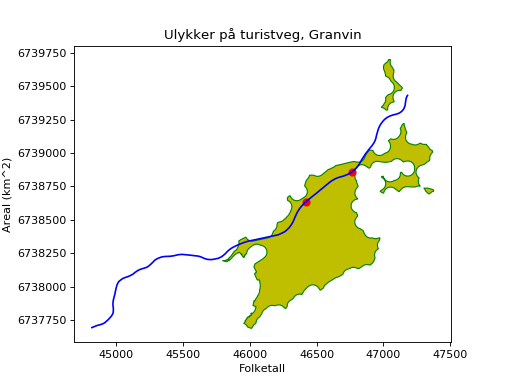

In [44]:
vistettsted = 'Granvin'
fig1, ax1 = plt.subplots()

ax1.set_title( "Ulykker på turistveg, " + vistettsted)
ax1.set_ylabel( 'Nord utm33-meter')
ax1.set_xlabel( 'Øst utm33-meter')
ax1.set_aspect('equal')

tettsted_m_turistveg_ulykker[ tettsted_m_turistveg_ulykker.Tettstedsn == 
        vistettsted ].geometry.plot( ax=ax1, color='y', edgecolor='g')

turist_i_tettsted[ turist_i_tettsted.Tettstedsn == 
                  vistettsted].geometry.plot( ax=ax1, color='b');

ulykker_i_tettsted[ ulykker_i_tettsted.Tettstedsn == 
                vistettsted].geometry.plot( ax=ax1, color='r', markersize = 40);


In [39]:
pd.options.display.max_columns = 100
ulykker_i_tettsted[ ulykker_i_tettsted.Tettstedsn == 
                vistettsted]


,Alvorligste skadegrad,Antall alvorlig skadet,Antall drepte i ulykken,Antall enheter,Antall kjørefelt,Antall lettere skadet,Antall meget alvorlig skadet,Bebyggelse,Dekketype,Fartsgrense,Felttype,Forsterket vegoppmerking,Føreforhold,"Geometri, punkt",Historisk hp,Historisk kilometerverdi,Historisk vegkategori,Historisk vegnummer,Historisk vegstatus,Kommunenr,Lysforhold,Midtdeler,Registreringsdato for fagdata,Stedfestingens nøyaktighet,Stedsforhold,Temperatur,Uhell kategori,Uhellskode,Ukedag,Ulykkesdato,Ulykkestidspunkt,Vegbredde,Vegnavn,Vegtype,Værforhold,antall vegsegmenter_left,fylke_left,geometry,hp_left,id_left,kategori_left,kommune_left,kortform_left,metadata_left,meter,nummer_left,region_left,status_left,stedfesting_left,vegavdeling_left,vegsegment nr_left,index_right,Tot_Bef,TETTNR,Tettstedsn,Areal_km2,Beff_tett,tettsted_m_turist_indeks_right,Link turistveg,Navn,Status,antall vegsegmenter_right,fra_meter,fylke_right,hp_right,id_right,kategori_right,kommune_right,kortform_right,metadata_right,nummer_right,region_right,status_right,stedfesting_right,strekningslengde,til_meter,vegavdeling_right,vegsegment nr_right
1135,Lettere skadd,0,0.0,2,NaN,1,0,Utenfor tettbebyggelse,"Asfalt, oljegrus",50.0,Vanlig kjørefelt,NaN,"Våt, bar veg",NaN,11.0,750.0,Riksveg,7,Eksisterende veg,1234.0,Dagslys,NaN,1999-10-13,NaN,Vegstrekning utenfor kryss/avkjørsel,13.0,Bilulykke,Vending foran kjørende i motsatt retning,Fredag,1999-09-03,10:30,6.5,NaN,Vanlig veg/gate,"God sikt, nedbør",1,12,POINT Z (46763.0022 6738857.92036 23.4),11,82042323,F,1234,1200 Fv7 hp11 m754,"{'type': {'id': 570, 'navn': 'Trafikkulykke'},...",754,7,3,V,"{'veglenkeid': 805637, 'posisjon': 0.677392833...",12,1,469,458,5291,Granvin,0.688947,664.782516,411,http://www.nasjonaleturistveger.no/no/hardanger,Hardanger,Nasjonal turistveg,73,0,12,11,401503414,F,1234,1200 Fv7 hp11 m0-3250,"{'type': {'id': 777, 'navn': 'Turistveg'}, 've...",7,3,V,"{'veglenkeid': 805637, 'fra_posisjon': 0.58009...",3250,3250,12,49
1436,Lettere skadd,0,0.0,2,NaN,1,0,Innenfor tettbebyggelse,Ukjent,50.0,Ukjent,NaN,"Tørr, bar veg",NaN,6.0,4700.0,Europaveg,68,Eksisterende veg,1234.0,Dagslys,NaN,NaN,NaN,Vegstrekning utenfor kryss/avkjørsel,NaN,Bilulykke,Forbikjøring,Fredag,1987-04-10,15:30,NaN,Granvin,Ukjent,"God sikt, opphold",1,12,POINT Z (46421.46778 6738635.54143 14.25162),11,82095956,F,1234,1200 Fv7 hp11 m1166,"{'type': {'id': 570, 'navn': 'Trafikkulykke'},...",1166,7,3,V,"{'veglenkeid': 805637, 'posisjon': 0.730621455...",12,1,469,458,5291,Granvin,0.688947,664.782516,411,http://www.nasjonaleturistveger.no/no/hardanger,Hardanger,Nasjonal turistveg,73,0,12,11,401503414,F,1234,1200 Fv7 hp11 m0-3250,"{'type': {'id': 777, 'navn': 'Turistveg'}, 've...",7,3,V,"{'veglenkeid': 805637, 'fra_posisjon': 0.58009...",3250,3250,12,49


In [17]:
len( ulykker_i_tettsted[ ulykker_i_tettsted['Alvorligste skadegrad'] == 'Drept' ])

21

In [18]:
# Dumper til fil: 

with open('ulykker_i_tettsted.json', 'w') as f:
    f.write(ulykker_i_tettsted.to_json())


<IPython.core.display.Javascript object>


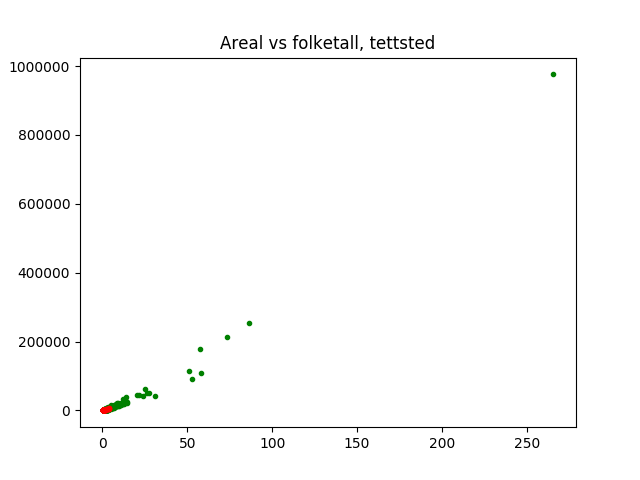

In [19]:

# ax2.plot( tettsted_m_turist.Areal_km2, tettsted_m_turist.Tot_Bef, '.r' )


,Tot_Bef,TETTNR,Tettstedsn,Areal_km2,Beff_tett,geometry
index_left,,,,,,
300,975744,0801,Oslo,265.652192,3673.013168,"(POLYGON ((266251.6812000013 6629989.145, 2662..."
442,252772,5001,Bergen,86.496447,2922.339680,"(POLYGON ((-38070.00590000088 6718696.3411, -3..."
109,213312,4522,Stavanger/Sandnes,73.607289,2897.973869,"(POLYGON ((-34431.14089999912 6556225.3978, -3..."
744,177617,6501,Trondheim,57.491220,3089.463031,(POLYGON ((268265.0573999999 7030054.580200002...
273,115137,2003,Drammen,50.984945,2258.254846,(POLYGON ((232735.5022999992 6624973.380599999...
148,109907,0022,Fredrikstad/Sarpsborg,58.183978,1888.956445,"(POLYGON ((264590.8479000007 6568949.3261, 264..."
143,92001,3005,Porsgrunn/Skien,52.675749,1746.553230,(POLYGON ((195972.8235999987 6553963.442600001...


In [21]:
# fjerner duplikater? 
tettsted.columns

Index(['Tot_Bef', 'TETTNR', 'Tettstedsn', 'Areal_km2', 'Beff_tett',
       'geometry'],
      dtype='object')